# Compulsory Assignment 3: Semantic segmentation

Please fill out the the group name, number, members and optionally the name below.

**Group number**:  40 \
**Group member 1**: Tor Erik Aasestad\
**Group member 2**: Tage Andersen \
**Group member 3**:  Elias Hartmarks \


# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. This is the biggest assignemnt of the semester, and therefore you get two weeks to work on it. However, we reccomend that **you start early**. This assignment has three semi-big sections, each of which build upon the last. So if you delay the assignment until the day before submission, you will most likely fail. This assignment is completed by doing the following. 
* Submit notebook as an .ipynb file to canvas.
* Submit notebook as an .pdf file to canvas.
* Submit the python script you run on ORION to canvas.
* Submit the SLURM script you run on ORION to canvas.
* Submit at least one of your model predictions to the Kaggle leaderboard, and attain a score that is higher than the *BEAT ME* score. 

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.



# Introduction 
This assignment will center around semantic segmentation of the dataset in the TGS salt identification challenge. Several of the Earths accumulations of oil and gas **also** have huge deposits of salt, which is easier to detect than the actual hydrocarbons. However, knowing where the salt deposits are precisely is still quite difficult, and segmentation of the seismic images is still something that requires expert interpretation of the images. This leads variable, and highly subjective renderings. To create more accurate, objective segmentations TGS (the worlds leading geoscience data company) have created this challenge to determine if a deep learning model is up to the task. 

## Dataset
In this assigmnet you will be given 3500 annotated images. The image, and mask dimensions are 128x128 pixels. With each image there follows an annotation mask where each pixel is classified as `1` (salt deposit) or `0` not salt deposit. The test-dataset contains 500 images, where no ground truth masks are given. To evualuate your model on the test dataset, submit your predictions to the Kaggle leaderboard.

## Assignment tasks

1. Implement a U-net model, and train it to segment the dataset.
2. Implement a U-net model that uses a pre-trained backbone model of your choice (VGGnet, ResNet, DarkNet, etc.), and train it to segment the dataset.
3. Train one of the models from part 1 or 2 on Orion, and compare the training times and attained performances.
4. Submit the best model prediction on Kaggle learderboard.


## Submissions to the Kaggle leaderboard

Link to the Kaggle leaderboard will be posted in the Canvas assignment.

```python
y_pred      = model.predict(X_test)                       # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False)        # Remember to store the dataframe to csv without the nameless index column.
```


# Library imports

In [1]:
import time
import os
from tqdm import tqdm # Cool progress bar

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as ks
import tensorflow as tf

SEED = 458 # Feel free to set another seed if you want to
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

from utilities import *
from visualization import *

# Data loading

Load the data from the HDF5 file `student_TGS_challenge.h5` that is available on Canvas, and Kaggle.
The data should be loaded in the same manner as in CA2. 

In [2]:
dataset_path = './student_TGS_challenge.h5'
with h5py.File(dataset_path,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X_train'])
    y_train = np.asarray(f['y_train'])
    X_test = np.asarray(f['X_test'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))



Datasets in file: ['X_test', 'X_train', 'y_train']
Nr. train images: 3500
Nr. test images: 500


In [3]:
# print the resolution and the number of channels for the train and test images
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape, X_test.shape)

X_train shape: (3500, 128, 128, 3) y_train shape: (3500, 128, 128) (500, 128, 128, 3)


# Visualization

Plot a few samples images and masks. Feel free to visualize any other aspects of the dataset that you feel are relevant. 

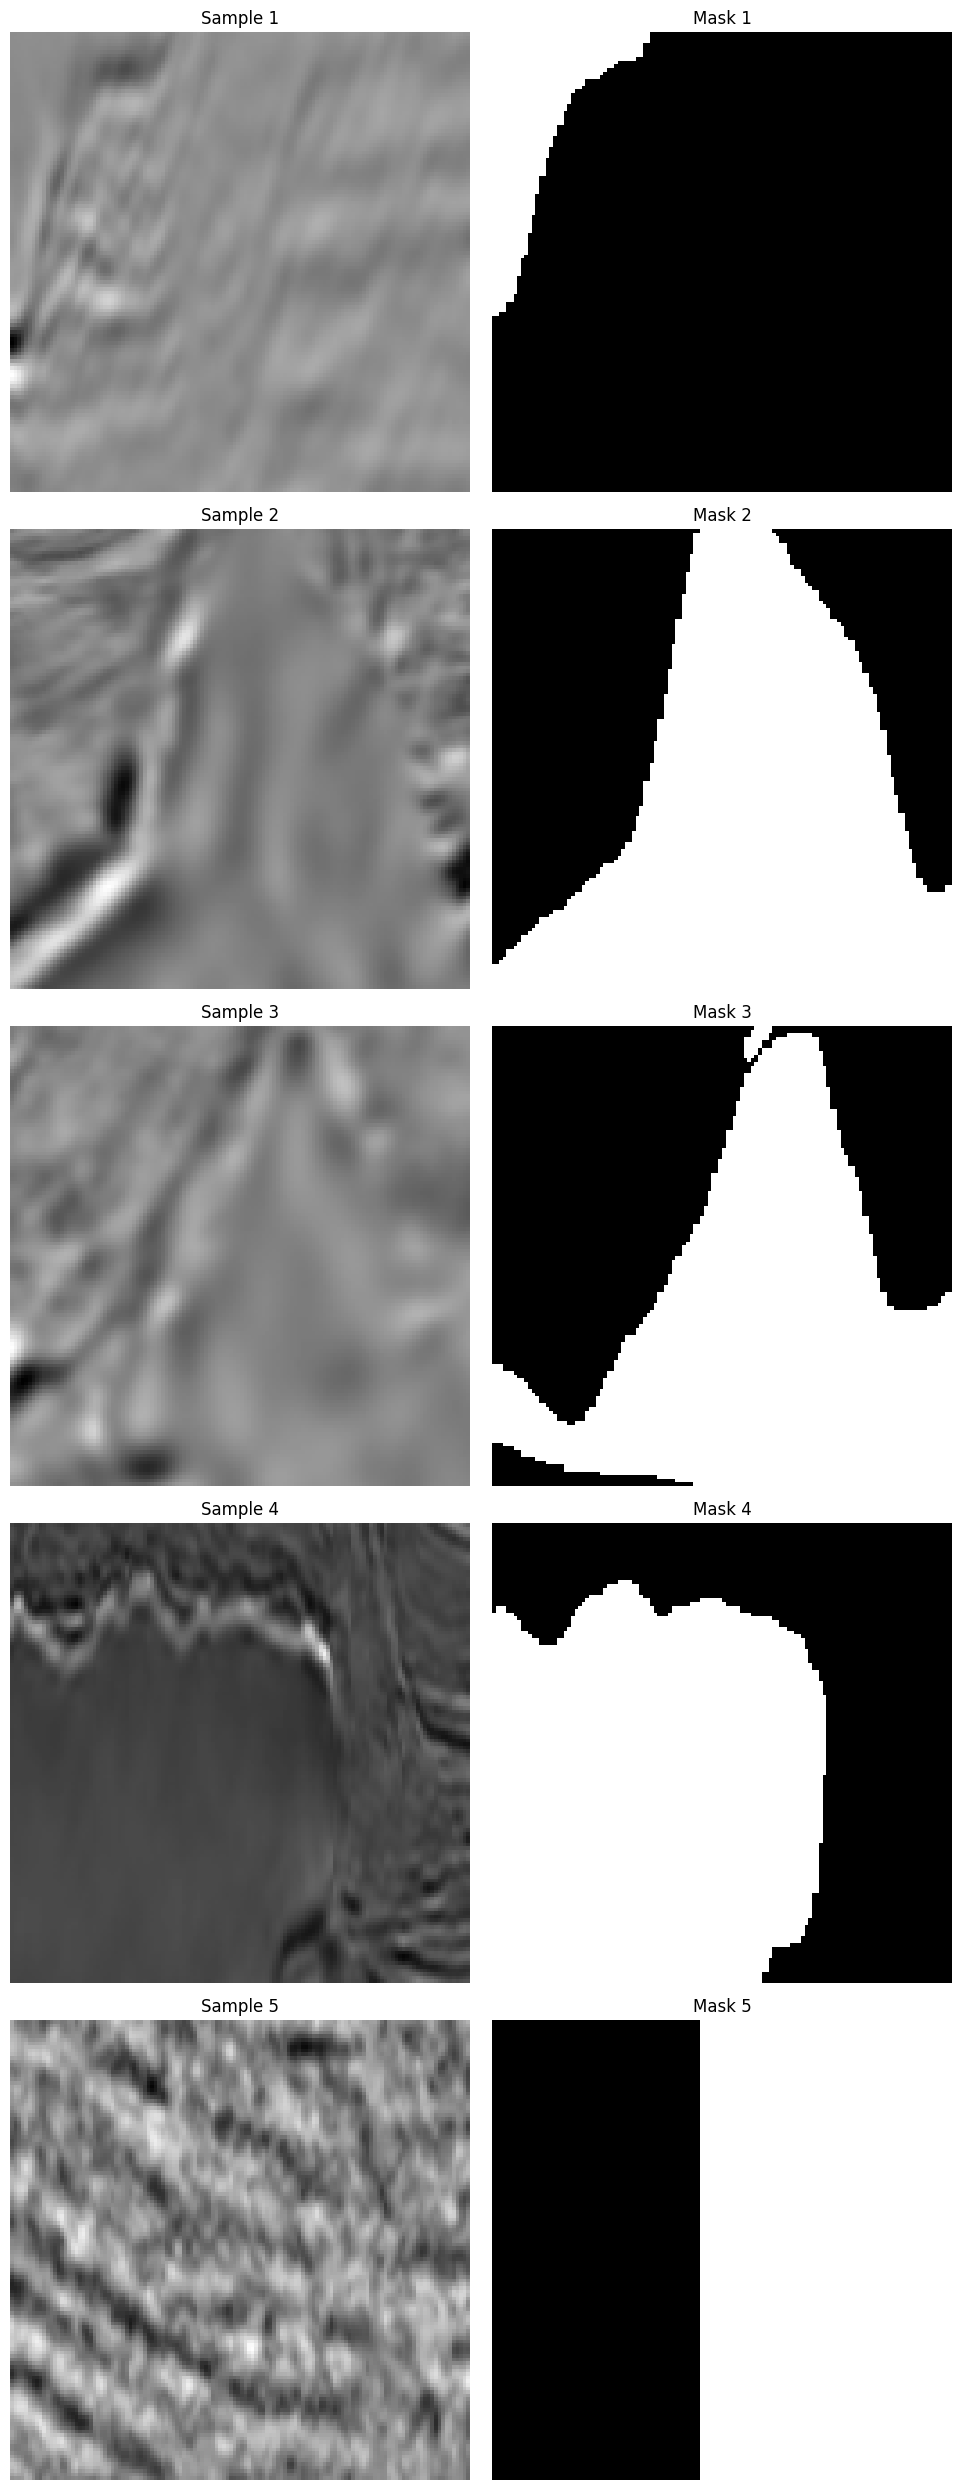

In [4]:
def plot_samples(X, y, num_samples=5):
    """Visualize sample images and their corresponding masks."""

    fig, ax = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        ax[i, 0].imshow(X[i, ...], cmap='gray')
        ax[i, 0].axis('off')
        ax[i, 0].set_title(f"Sample {i+1}")

        ax[i, 1].imshow(y[i, ...], cmap='gray') 
        ax[i, 1].axis('off')
        ax[i, 1].set_title(f"Mask {i+1}")

    plt.tight_layout()
    plt.show()

plot_samples(X_train, y_train)


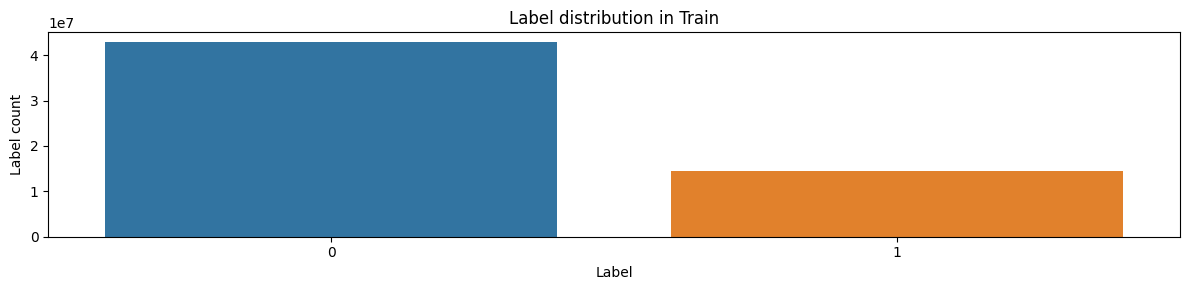

In [5]:
# Flatten y_train to make it 1D and then get unique counts
unique_labels, counts = np.unique(y_train, return_counts=True)

# Plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.barplot(x=unique_labels, y=counts, ax=ax)

ax.set_xlabel('Label')
ax.set_ylabel('Label count')
ax.set_title('Label distribution in Train')
fig.tight_layout()
plt.show()

# Preprocessing

Preprocess the dataset in whatever ways you think are helpful. 

In [6]:
# Find the maximum pixel value from the training data
max_pixel_value = np.max(X_train)

# Normalize the images to [0,1] using the max pixel value from the training data
X_train = X_train.astype("float32") / max_pixel_value
X_test = X_test.astype("float32") / max_pixel_value


# Part 1: Implementing U-net

## Intersection over Union

The IoU score is a popular metric in both segmentation and object detection problems. 

If you want to use the `plot_training_history` function in the `visualization.py` library remember to compile the model with the TP, TN, FP, FN metrics such that you can estimate the *Intersection-over-Union*. **However, it is voluntary to estimate IoU**

See example below:

```python
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from utilities import F1_score, 
from visualization import plot_training_history, 
...
model.compile(optimizer='Something', 
                  loss='Something else', 
                  metrics=[FalseNegatives(),
                           FalsePositives(),
                           TrueNegatives(),
                           TruePositives(),
                           F1_score,
                           OtherMetricOfChoice])

training_history = model.fit(X_train, y_train, ...)
plot_training_history(training_history)
```

You have also been provided with a custom F1-score metric in the `utilities.py` library, which is specific for image segmentation. **This is mandatory to use when compiling the model**.


## Task 1.1 Model implementation

Implement the classical U-net structure that you have learned about in the lectures. Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. **Remember to compile with the F1-score metric**. 


In [7]:
"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives


input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 32, dropout = 0.0, batchnorm = True, n_classes = 1)
batch_size = 32
epochs = 2
validation_split = 1/5


## Task 1.2 Train the model, and plot the training history
Feel free to use the `plot_training_history` function from the provided library `utilities.py`

In [9]:


# Get the current working directory
current_directory = os.getcwd()

# Define the substring you want to check for
substring = "dat300-h23-40"

# Check if the substring is in the current working directory
if substring in current_directory:
    MODEL_PATH = "/mnt/users/dat300-h23-40/ca3/models/model.keras"
    PICTURE_PATH = "/mnt/users/dat300-h23-40/ca3/models/model.png"
    batch_size = 128
    epochs = 40
else:
    MODEL_PATH = "../models/model.keras"
    PICTURE_PATH = "../models/model.png"

# Create a validation split

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[FalseNegatives(),
                       FalsePositives(),
                       TrueNegatives(),
                       TruePositives(),
                       F1_score])
# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=validation_split)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.5f} seconds.")
print(f"Per epoch: {elapsed_time/epochs:.5f} seconds.")

model.save(MODEL_PATH)

Epoch 1/20
88/88 [==============================] - 381s 4s/step - loss: 11.4495 - false_negatives: 0.0000e+00 - false_positives: 34444336.0000 - true_negatives: 0.0000e+00 - true_positives: 11430870.0000 - F1_score: 0.3945 - val_loss: 11.2230 - val_false_negatives: 0.0000e+00 - val_false_positives: 8440730.0000 - val_true_negatives: 0.0000e+00 - val_true_positives: 3028070.0000 - val_F1_score: 0.4150
Epoch 2/20
88/88 [==============================] - 369s 4s/step - loss: 11.4496 - false_negatives: 0.0000e+00 - false_positives: 34444328.0000 - true_negatives: 0.0000e+00 - true_positives: 11430870.0000 - F1_score: 0.3952 - val_loss: 11.2230 - val_false_negatives: 0.0000e+00 - val_false_positives: 8440730.0000 - val_true_negatives: 0.0000e+00 - val_true_positives: 3028070.0000 - val_F1_score: 0.4150
Epoch 3/20
88/88 [==============================] - 362s 4s/step - loss: 11.4495 - false_negatives: 0.0000e+00 - false_positives: 34444332.0000 - true_negatives: 0.0000e+00 - true_positives:

dict_keys(['loss', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'F1_score', 'val_loss', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives', 'val_F1_score'])


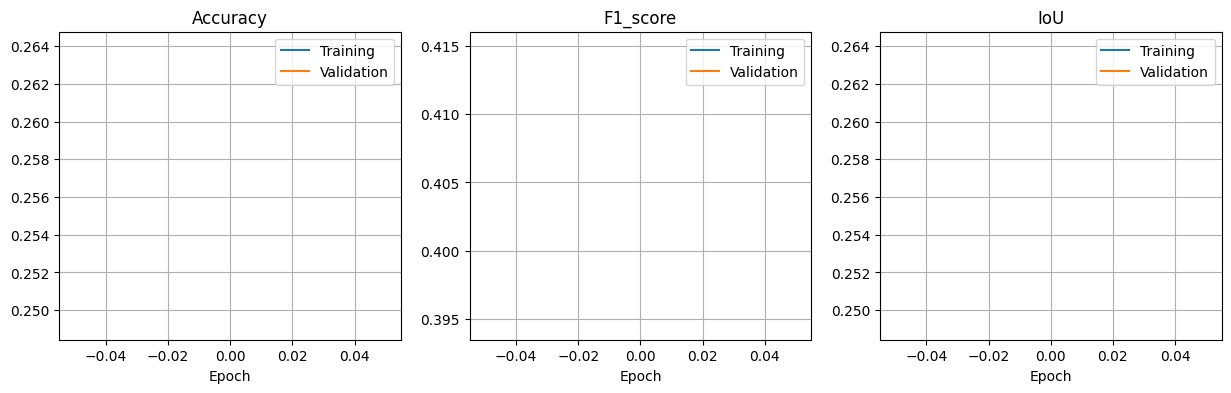

In [ ]:
print(history.history.keys())
plot_training_history(history)

## Task 1.3 Visualize model predictions

Make a plot that illustrates the original image, the predicted mask, and the ground truth mask. 

1/1 [==============================] - 1s 502ms/step


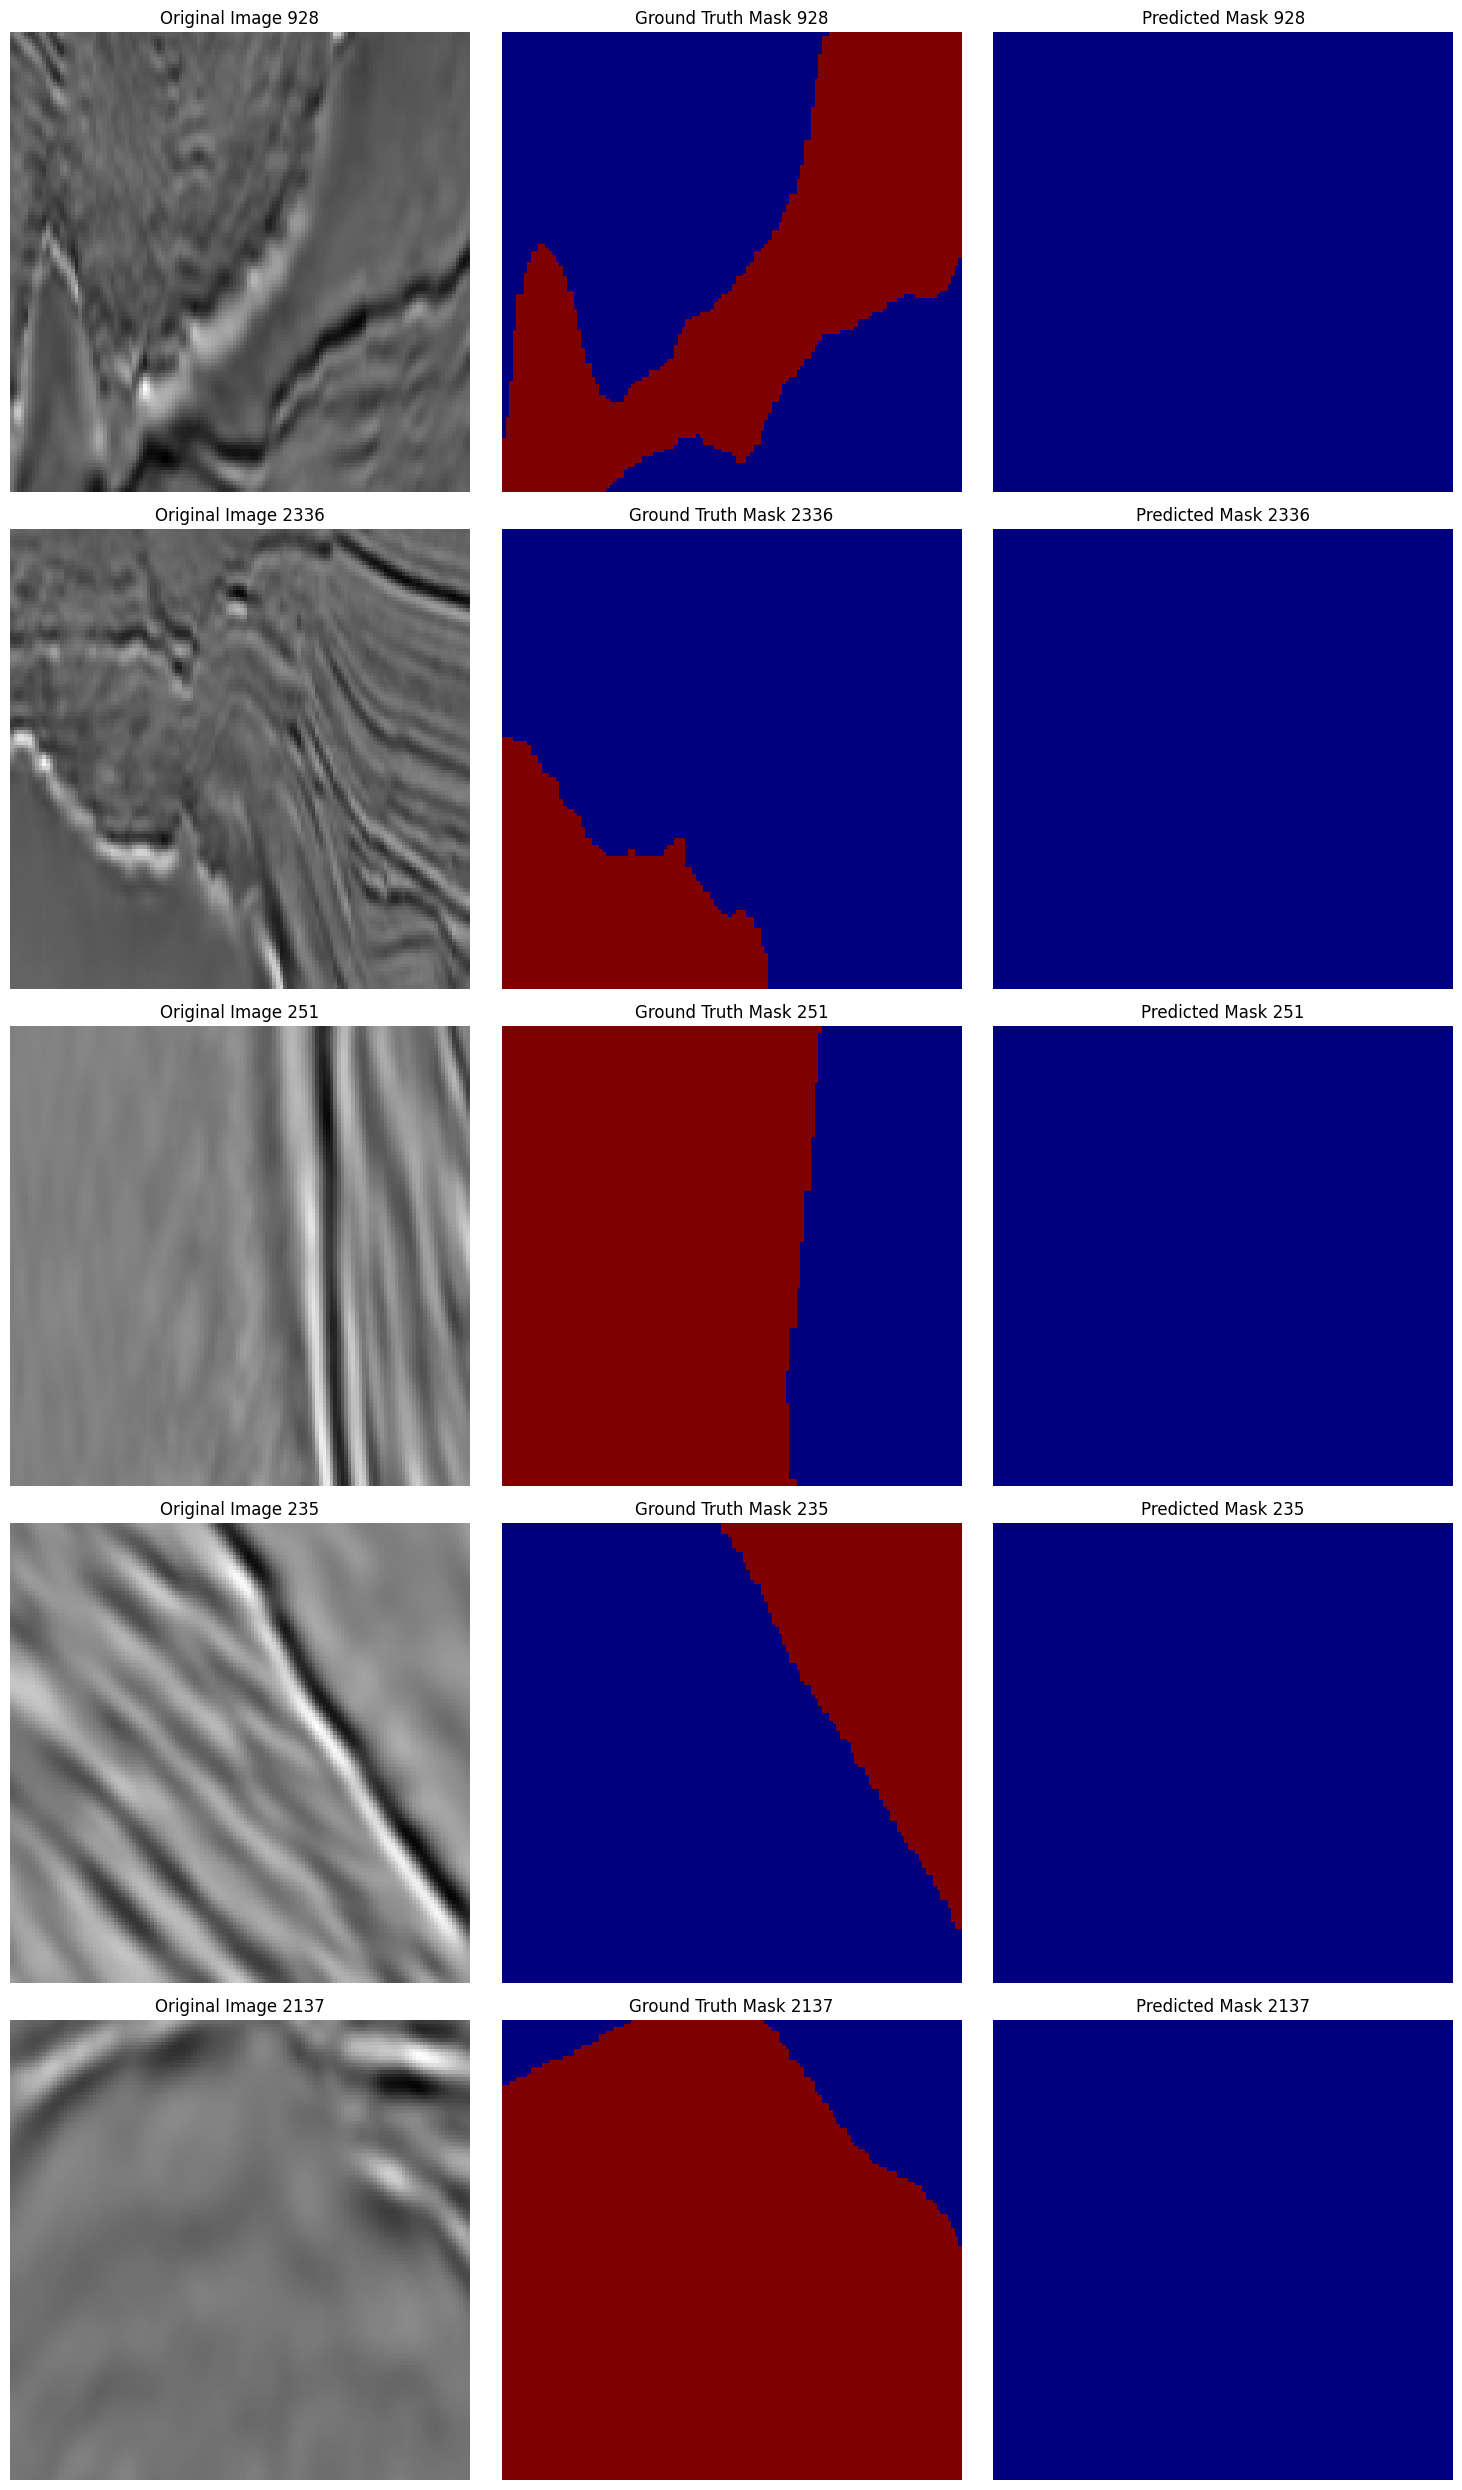

In [ ]:
def plot_predictions(X, y_true, y_pred, indices, num_samples=5):
    """Plot the original image, ground truth mask, and predicted mask."""
    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices[:num_samples]):

        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[idx])
        plt.title(f"Original Image {idx}")
        plt.axis('off')

        # Ground Truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_true[idx].squeeze(), cmap='jet')
        plt.title(f"Ground Truth Mask {idx}")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[i].squeeze() > 0.5, cmap='jet')
        plt.title(f"Predicted Mask {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate predictions on a subset
subset_indices = np.random.choice(len(X_train), 5, replace=False)  # Selecting 5 random samples
y_pred = model.predict(X_train[subset_indices])

# Call the plotting function
plot_predictions(X_train, y_train, y_pred, subset_indices)

# Part 2: Implementing U-net with transfer learning

Implement a model with the U-net structure that you have learned about in the lectures, but now with a pre-trained backbone. There are many pre-trained back-bones to choose from. Pick freely from the selection here [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), or here [Keras model scores](https://keras.io/api/applications/) (nicer table in the second link). Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. Many of the backbones available are quite big, so you might find it quite time-consuming to train them on your personal computers. It might be expedient to only train them for 1-5 epochs on your PCs, and do the full training on Orion in Part 3. 

## Task 2.1 Transfer learning model implementation

Implement a U-net model utilizing the pre-trained weights of a publically available network. **Remember to compile with the F1-score metric**.

In [ ]:
pre_trained_model = ks.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

model_with_pretrain = ks.models.Sequential()
model_with_pretrain.add(pre_trained_model)
model_with_pretrain.add(ks.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(512, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(512, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(256, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(256, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(128, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(128, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(64, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(64, 3, activation='relu', padding='same'))
model_with_pretrain.add(ks.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same'))
model_with_pretrain.add(ks.layers.Conv2D(1, 1, activation='sigmoid', padding='same'))

# Compile the model with appropriate loss function and metrics
model_with_pretrain.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[FalseNegatives(),
                    FalsePositives(),
                    TrueNegatives(),
                    TruePositives(),
                    F1_score])


## Task 2.2 Train the transfer learning model and plot the training history

Feel free to use the `plot_training_history` function from the provided library `utilities.py`

In [ ]:
#Using the same number of epochs and batch size as before, train the model with the pre-trained weights. 
start_time = time.time()
history_pre_trained = model_with_pretrain.fit(X_train, y_train, 
                                                batch_size=batch_size, 
                                                epochs=epochs, 
                                                validation_split=validation_split,
                                                #mute the training output
                                                verbose=0)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training took {elapsed_time:.5f} seconds.")
print(f"Per epoch: {elapsed_time/epochs:.5f} seconds.")

Training took 205.63958 seconds.
Per epoch: 205.63958 seconds.


dict_keys(['loss', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'F1_score', 'val_loss', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives', 'val_F1_score'])


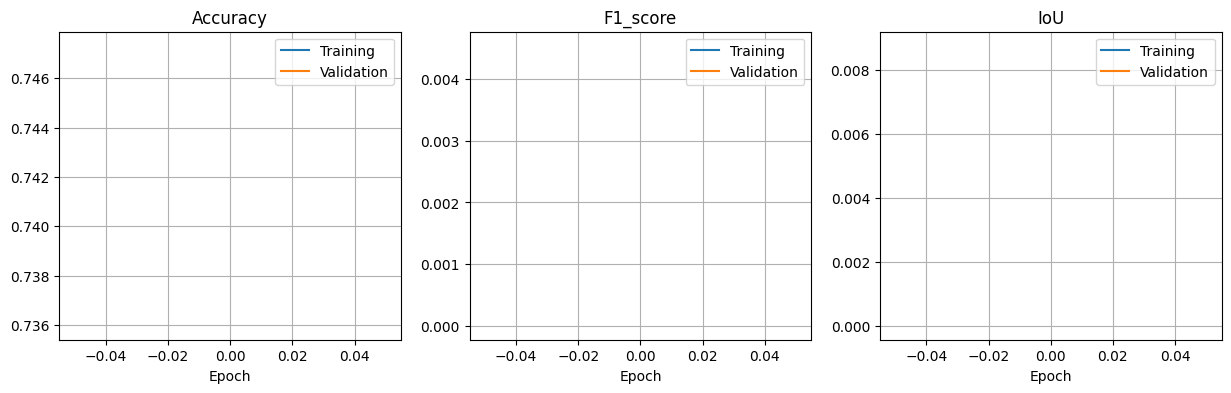

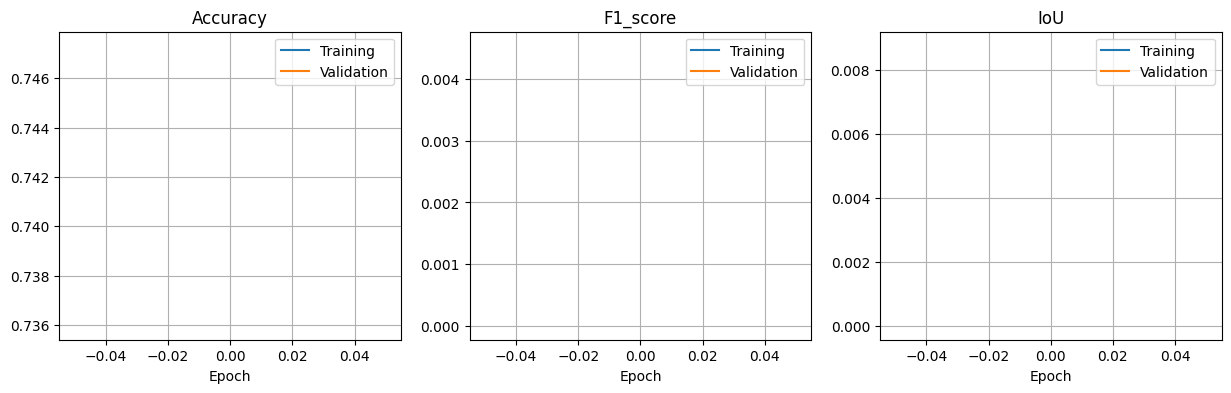

In [ ]:
print(history_pre_trained.history.keys())
plot_training_history_and_return(history_pre_trained)


# Part 3: Training your model Orion

Use the lecture slides from the Orion-lecture to get started.
1. Put one of your model implementations into a python script (`.py`)
2. Transfer that script to Orion.
3. Change the relevant path variables in your python script (path-to-data for example), and make sure that you record the time it takes to train the model in the script. This can be done using the `time` library for example.
4. Set up a SLURM-script to train your model, please use the example from the Orion lecture as a base.
5. Submit your SLURM job, and let the magic happen. 

If you wish to use a model trained on Orion to make a Kaggle submission, remeber to save the model, such that you can transfer it to your local computer to make a prediction on `X_test`, or test the model on Orion directly if you want to. 

## Tips

If you compiled, trained and stored a model on Orion with a custom performance metric (such as F1-score), remember to specify that metric when loading the model on your computer again.

Loading a saved model:
```python
trained_model = tf.keras.models.load_model('some/path/to/my_trained_model.keras', custom_objects={'F1_score': F1_score})
```

Loading a checkpoint:
```python
trained_model = tf.keras.saving.load_model('some/path/to/my_trained_model_checkpoint', custom_objects={'F1_score': F1_score})
```

# Discussion

**Question 1: Which model architectures did you explore, and what type of hyperparameter optimization did you try?**
**Answer 1:** We tried several pretrained models. From Vgg16 to Enet etc, we also tried tuning the learning-rates and preprocessing.

**Question 2: Which of the model(s) did you choose to train on Orion, and how long did it take to train it on Orion?**

**Answer 2:**  We chose to use the pretrained architecture model, which uses MobileNet-v2, on Orion. It took x to train it on Orion. 

**Question 3: What where the biggest challenges with this assignment?**

**Answer 3:** Working with Orion, getting a good workflow for the files and maintaining a oranized workflow. Errors were also quite complicated, and a lot of time was wasted looking for fixes. 

# Kaggle submission

Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard.
Link to the Kaggle leaderboard will be posted in the Canvas assignment.

In [ ]:
y_pred = model.predict(X_test)

# Flatten prediction
y_pred      = model.predict(X_test)                       # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= 0.5] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission_newtest.csv', index=False)   

16/16 [==============================] - 14s 837ms/step
